## Variational Methods in TensorFlow Probability  

In this notebook, we focus on understanding the APIs for the different methods. 
We do not evaluate the performance. 


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190426
TF  Version 2.0.0-alpha0


Loading the Boston data

In [42]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X))
X = scaler.transform(X)
X = np.asarray(X, np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X = X_train
y = y_train
X.shape, y.shape, y_train.shape, y_test.shape, X.min(), X.max()

StandardScaler(copy=True, with_mean=True, with_std=True)


((455, 13), (455,), (455,), (51,), -3.9071934, 9.93393)

## Different approches

In [43]:
sgd = tf.keras.optimizers.SGD(lr=.01, momentum=0.9, nesterov=True)
epochs = 500
bs = 100


### No Bayesian Regularisation

In [44]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation = 'tanh', input_shape=(X.shape[1],)))
model.add(tf.keras.layers.Dense(1,))
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
hist_no_variational = model.fit(X, y, batch_size=bs, epochs=epochs,verbose=False)
print('Loss of training set last 10 entries: ', np.sqrt(hist_no_variational.history['loss'][-10:]))
print('RMSE on the test set: ', np.sqrt(np.mean((model(X_test)[:,0] - y_test)**2)))

Loss of training set last 10 entries:  [2.01717272 2.00328738 2.00330255 2.00447599 2.01045881 1.99637964
 2.00087338 2.01167406 2.02040887 2.00833306]
RMSE on the test set:  3.249037


### Variational Layers (Dense Reparametrisation)

In [45]:
# Here we downweight the LK costs. In that case there should be no difference to the standard case
#kernel_divergence_fn=lambda q, p, _: 0.0#tfp.distributions.kl_divergence(q, p) / 510.0
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
model = tf.keras.Sequential()
model.add(tfp.layers.DenseReparameterization(10, activation = 'tanh', kernel_divergence_fn=kernel_divergence_fn,input_shape=(X.shape[1],)))
model.add(tfp.layers.DenseReparameterization(1,kernel_divergence_fn=kernel_divergence_fn))
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
hist_scaled_DRep_variational = model.fit(X, y, batch_size=bs,epochs=epochs,verbose=False)
print('Loss of training set last 10 entries: ', np.sqrt(hist_scaled_DRep_variational.history['loss'][-10:]))
for _ in range(4):
    print('RMSE on the test set: ', np.sqrt(np.mean((model.predict(X_test)[:,0] - y_test)**2)))

Loss of training set last 10 entries:  [2.45468335 2.53248191 2.46293662 2.47583806 2.45069494 2.48261253
 2.45702365 2.48282892 2.521879   2.51532076]
RMSE on the test set:  3.1146519944744617
RMSE on the test set:  3.0783599764567113
RMSE on the test set:  3.2524960686554683
RMSE on the test set:  3.037224663589791


In [46]:
#Prediction for different runs
print(model.predict(X_test)[0:5,0]) #We sample from different weights
print(model.predict(X_test)[0:5,0])

[25.201212 34.06704  17.324883 22.633097 15.46351 ]
[25.134434 35.165783 16.204508 22.908169 15.124758]


### Variational Layers (Flipout)

In [47]:
### Flipout
# Here we downweight the LK costs. In that case there should be no difference to the standard case
#kernel_divergence_fn=lambda q, p, _: 0.0#tfp.distributions.kl_divergence(q, p) / 510.0
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
model = tf.keras.Sequential()
model.add(tfp.layers.DenseFlipout(10, activation = 'tanh', kernel_divergence_fn=kernel_divergence_fn,input_shape=(X.shape[1],)))
model.add(tfp.layers.DenseFlipout(1,kernel_divergence_fn=kernel_divergence_fn))
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
hist_scaled_flip_variational = model.fit(X, y, batch_size=bs,epochs=epochs,verbose=False)
print('Loss of training set last 10 entries: ', np.sqrt(hist_scaled_flip_variational.history['loss'][-10:]))
print('RMSE on the test set: ', np.sqrt(np.mean((model.predict(X_test)[:,0] - y_test)**2)))


Loss of training set last 10 entries:  [2.30834976 2.35250243 2.343324   2.341422   2.34732543 2.29814696
 2.33719315 2.38382258 2.39549383 2.36578912]
RMSE on the test set:  3.23310031596255


### Variational Layers (Novel API in Dense)
Is this the new API they will introduce, or just a hack to make a smooth presentation on the 
TF developer day?

TODO work in progress

In [9]:
# In more easy code
# def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
#   n = kernel_size + bias_size #Number of weights
#   c = np.log(np.expm1(1.)) #Magic number for offsetting in softpuls
#   
#   model = tf.keras.Sequential()
#   # Creating 2n variables as a starting point
#   variables = tfp.layers.VariableLayer(2 * n, dtype=dtype, name='post_weights')
#   model.add(variables)
#   model.add(tfp.layers.DistributionLambda(
#       lambda t: tfd.Independent(tfd.Normal(
#           loc=t[..., :n],scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
#                                 reinterpreted_batch_ndims=1))
#       )
#   return (model)
# 
# 
# def prior_trainable(kernel_size, bias_size=0, dtype=None):
#   n = kernel_size + bias_size
# 
#   model = tf.keras.Sequential()
#   # Creating n variables as a starting point (we only learn mu)
#   variables = tfp.layers.VariableLayer(n, dtype=dtype)
#   model.add(variables)
#   model.add(tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#            tfd.Normal(loc=t, scale=1),
#            reinterpreted_batch_ndims=1)))
#   return (model)
# 
# 
# model = tf.keras.Sequential()
# model.add(tfp.layers.DenseVariational(10,
#                                       make_posterior_fn=posterior_mean_field,
#                                       make_prior_fn=prior_trainable,
#                                       activation = 'tanh', input_shape=(X.shape[1],)))
# model.add(tfp.layers.DenseVariational(1,
#                                       make_posterior_fn=posterior_mean_field,
#                                       make_prior_fn=prior_trainable,
#                                       activation = 'tanh', input_shape=(X.shape[1],)))
# model.compile(loss='mse', optimizer=sgd, metrics=['mse'], epochs=epochs, batch_size=bs)
# hist_DenseVariational= model.fit(X, y, batch_size=bs,epochs=epochs,verbose=False)


### Finishing with a TFP layer

In [48]:
# Distribution 
## Definition of the custom parametrized distribution
def my_gauss(mu):
  return tfd.Normal(loc=mu, scale=1)

kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)

inputs = tf.keras.layers.Input(shape=(X.shape[1],))
h = tfp.layers.DenseFlipout(10,  activation = 'tanh', kernel_divergence_fn=kernel_divergence_fn)(inputs)
out = tfp.layers.DenseFlipout(1, kernel_divergence_fn=kernel_divergence_fn)(h)
p_y = tfp.layers.DistributionLambda(my_gauss)(out)
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)

# Do inference.
def negloglik(y_true, p_y):
  return -p_y.log_prob(y_true)

model.compile(loss=negloglik, optimizer=sgd)
hist_variational_scaled_fo_lasttfp = model.fit(X, y, batch_size=bs,epochs=epochs,verbose=False)
print('Loss of training set last 10 entries: ', np.sqrt(hist_variational_scaled_fo_lasttfp.history['loss'][-10:]))


Loss of training set last 10 entries:  [1.99331163 2.00379632 2.01588275 1.98332039 1.9858013  1.98259823
 1.99232096 2.00058253 2.0090468  1.98341893]


In [51]:
#model.predict(X_test) #Should give values but does not
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean())
print("Mean ", model_mean.predict(X_test)[0:2])
print('RMSE on the test set: ', np.sqrt(np.mean((model_mean.predict(X_test)[:,0] - y_test)**2)))


model_std = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean())
print("Sdev ",model_std.predict(X_test)[0:2])

model_lp_at01 = tf.keras.models.Model(inputs=inputs, outputs=p_y.log_prob(0.1))
print("Model log at ", model_lp_at01.predict(X_test)[0:2])

Mean  [[24.009594]
 [32.8211  ]]
RMSE on the test set:  2.671469794721395
Sdev  [[24.372652]
 [33.429905]]
Model log at  [[-310.08273]
 [-622.7005 ]]


Comparison of the different methods

(0, 20)

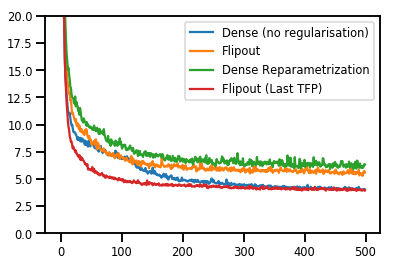

In [50]:
plt.plot(hist_no_variational.history['loss'])
plt.plot(hist_scaled_flip_variational.history['loss'])
plt.plot(hist_scaled_DRep_variational.history['loss'])
plt.plot(hist_variational_scaled_fo_lasttfp.history['loss'])
plt.legend(('Dense (no regularisation)', 'Flipout', 'Dense Reparametrization','Flipout (Last TFP)'))
plt.ylim(0,20)
